In [1]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# loading the data from csv file to a pandas Dataframe
df = pd.read_csv("/content/email.csv",  encoding="latin-1")

In [3]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [4]:
print("Dataset shape:", df.shape)
print(df['label'].value_counts())

Dataset shape: (83448, 2)
label
1    43910
0    39538
Name: count, dtype: int64


In [5]:
# Step 3: Text cleaning function
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r'escapenumber+', ' ', text)
    text = re.sub(r'\S+@\S+', '', text)  # remove email addresses
    text = re.sub(r'http\S+|www.\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = text.strip()
    return text

# Apply cleaning
df['text'] = df['text'].apply(clean_text)
df = df[df['text'] != '']  # remove empty rows after cleaning

In [6]:
df.head(10)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday may...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
5,0,larry king live at p m et on friday june cnn t...
6,0,michael pobega wrote im not sure if its the mp...
7,0,hi i have this error tr sample train rbind iri...
8,1,works gateway world art explore tattooing full...
9,1,upon this account he is not only very cautious...


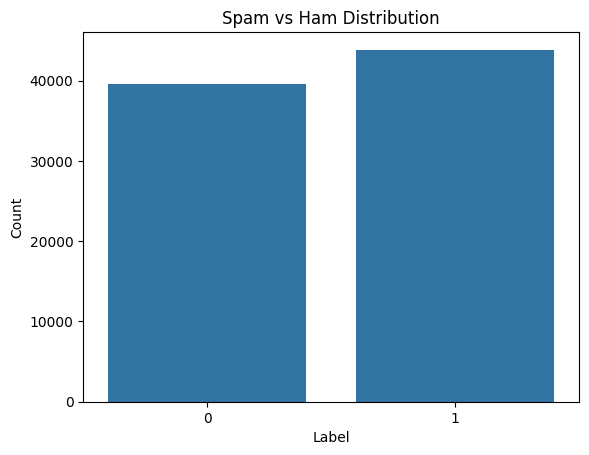

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count of spam vs ham in dataset
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [8]:
# Step 4: Split dataset into train and test
X = df['text']
y = df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 66708
Testing samples: 16678


In [11]:
tfidf = TfidfVectorizer(
    stop_words='english',  # remove common English stopwords
    max_df=0.95,           # ignore very common words
    min_df=5,               # ignore very rare words
    ngram_range=(1,2)
)

In [12]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
print("Number of features after TF-IDF:", X_train_tfidf.shape[1])

Number of features after TF-IDF: 269512


In [14]:
# Train LinearSVC
from sklearn.svm import LinearSVC

svc_model = LinearSVC(max_iter=5000)  # increase max_iter if convergence warning
svc_model.fit(X_train_tfidf, y_train)

LinearSVC(max_iter=5000)

In [15]:
# Predictions
y_pred = svc_model.predict(X_test_tfidf)

In [16]:
# Evaluation

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9905864012471519

Confusion Matrix:
 [[7789  118]
 [  39 8732]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7907
           1       0.99      1.00      0.99      8771

    accuracy                           0.99     16678
   macro avg       0.99      0.99      0.99     16678
weighted avg       0.99      0.99      0.99     16678



In [17]:
# Calibrate to get probabilities
from sklearn.calibration import CalibratedClassifierCV

model = CalibratedClassifierCV(svc_model)  # adds predict_proba
model.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(estimator=LinearSVC(max_iter=5000))

In [28]:
def predict_spam(text):
    # Clean the text
    cleaned = clean_text(text)

    # Transform text to TF-IDF vector
    vector = tfidf.transform([cleaned])

    # Predict class (0=Ham, 1=Spam)
    prediction = model.predict(vector)[0]

    # Get confidence/probability of being spam
    probability = model.predict_proba(vector)[0][1]  # index 1 = spam

    # Print results
    print("Message:\n", text)
    print("\nPrediction:", "Spam" if prediction == 1 else "Ham")
    print("Spam Confidence Score:", round(probability*100, 2), "%")

In [29]:
sample_text = """
From IT Roles to AI-First Careers in 2026

Hi Learner,

AI is evolving beyond automation.

The next wave is Agentic AI, systems that can reason, plan, and act autonomously.

Step into future-ready AI careers with Edureka’s Agentic AI Training Program, built for professionals aiming to
lead the AI revolution in 2026.

Why AI in 2026?

$55–60B GenAI market by 2026, growing at 40%+ annually
Traditional IT roles are evolving into AI-first careers
Make this year count—build skills that define your future.

New Year Bonus: Use code EDNY10

for Flat 20% off

"""

predict_spam(sample_text)

Message:
 
From IT Roles to AI-First Careers in 2026

Hi Learner,

AI is evolving beyond automation.

The next wave is Agentic AI, systems that can reason, plan, and act autonomously.

Step into future-ready AI careers with Edureka’s Agentic AI Training Program, built for professionals aiming to 
lead the AI revolution in 2026.

Why AI in 2026?

$55–60B GenAI market by 2026, growing at 40%+ annually
Traditional IT roles are evolving into AI-first careers
Make this year count—build skills that define your future.

New Year Bonus: Use code EDNY10

for Flat 20% off



Prediction: Spam
Spam Confidence Score: 98.28 %


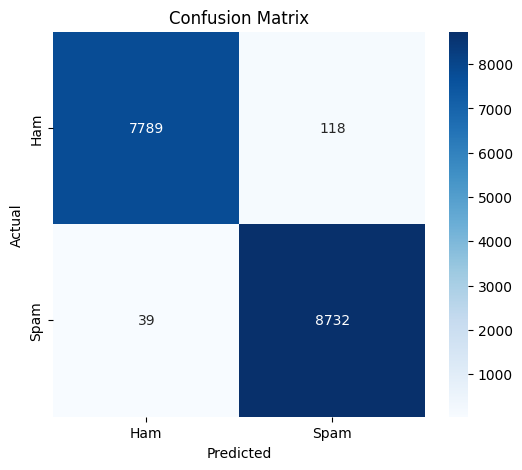

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

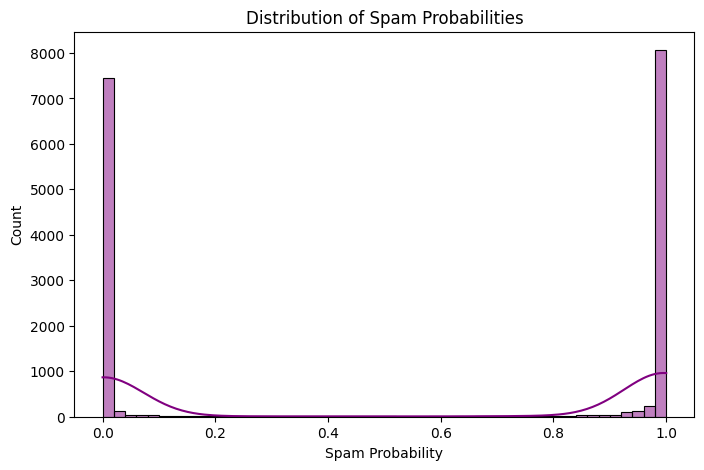

In [22]:
# Get spam probabilities for test set
spam_probs = model.predict_proba(X_test_tfidf)[:,1]

plt.figure(figsize=(8,5))
sns.histplot(spam_probs, bins=50, kde=True, color='purple')
plt.title("Distribution of Spam Probabilities")
plt.xlabel("Spam Probability")
plt.ylabel("Count")
plt.show()

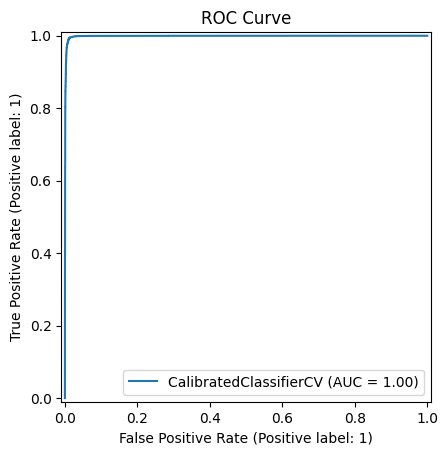

In [23]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(model, X_test_tfidf, y_test)
plt.title("ROC Curve")
plt.show()

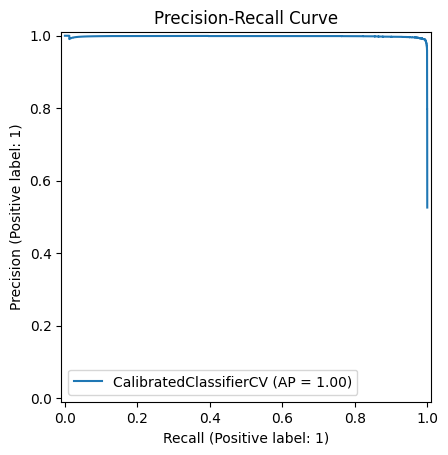

In [24]:
PrecisionRecallDisplay.from_estimator(model, X_test_tfidf, y_test)
plt.title("Precision-Recall Curve")
plt.show()

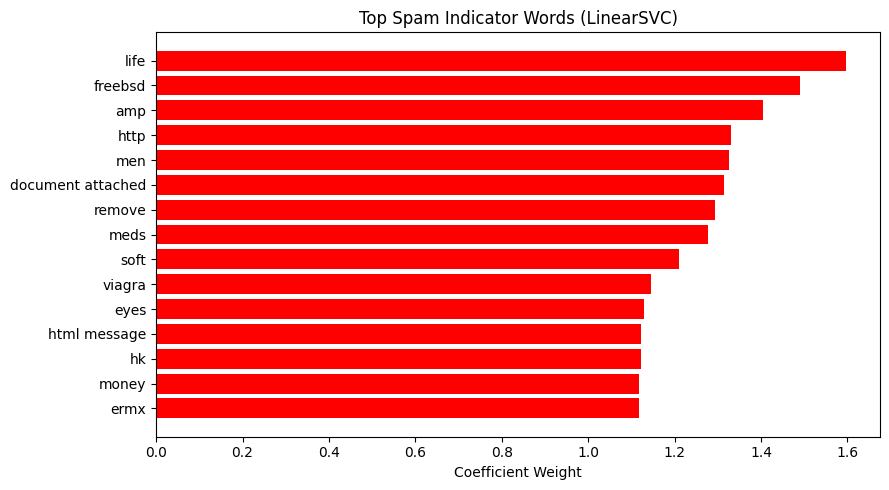

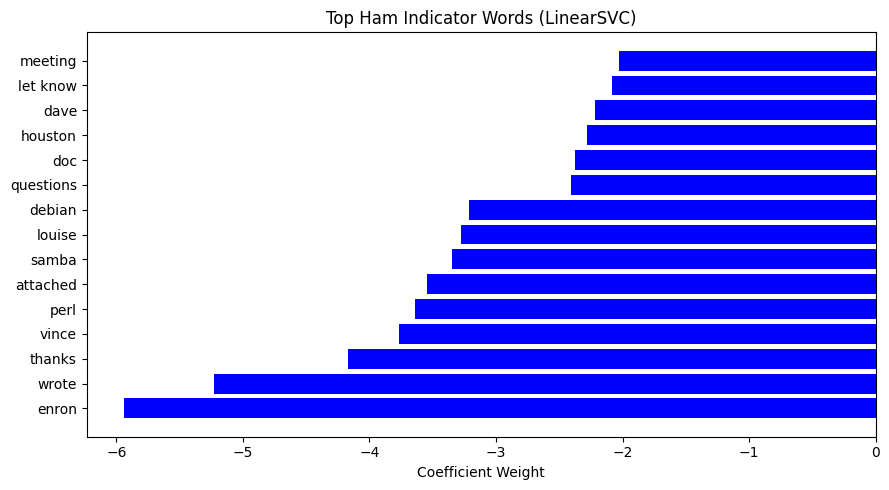

In [27]:
import numpy as np
import matplotlib.pyplot as plt

linear_svc_for_coef = svc_model

# feature names from your TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# coefficients from your LinearSVC (before calibration)
coefs = linear_svc_for_coef.coef_[0]  # 1D array

# Get indices of top spam and ham words
top_spam_idx = np.argsort(coefs)[-15:]  # highest positive weights
top_ham_idx  = np.argsort(coefs)[:15]   # lowest (most negative) weights

# Top Spam Words Plot
plt.figure(figsize=(9,5))
plt.barh(feature_names[top_spam_idx], coefs[top_spam_idx], color='red')
plt.title("Top Spam Indicator Words (LinearSVC)")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

# Top Ham Words Plot
plt.figure(figsize=(9,5))
plt.barh(feature_names[top_ham_idx], coefs[top_ham_idx], color='blue')
plt.title("Top Ham Indicator Words (LinearSVC)")
plt.xlabel("Coefficient Weight")
plt.tight_layout()
plt.show()

In [30]:
import joblib

joblib.dump(model, "spam_classifier.pkl")

joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']